## Demo Skript to determine single pictures of bunnies from group photos

In [1]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 

import matplotlib.pyplot as plt


# Add the project root to sys.path so 'config' can be imported
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import torch
from torchvision import transforms

from PIL import Image
import pytorch_lightning as pl

from config.load_configuration import load_configuration
config = load_configuration()

from utils.scraper import remove_visual_duplicates

pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

# import the model
# This is a pre-trained Faster R-CNN model with a ResNet-50 backbone
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Seed set to 42


PC Name: DESKTOP-MIKA
Loaded configuration from ../config/config_mika.yaml


f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
# Helper function to get bounding boxes for rabbits
def get_rabbit_boxes(image, threshold=0.4):                                                         #TODO: adjust threshold as necessary
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(image)
    with torch.no_grad():
        prediction = model([img_tensor])[0]
    boxes = []
    labels = prediction['labels'].tolist()
    scores = prediction['scores'].tolist()

    accepted_labels = [16, 17, 18, 19, 20, 21, 22, 23, 24, 88, 74]                                  # COCO classes for animals
    for box, label, score in zip(prediction['boxes'], labels, scores):
        if label in accepted_labels and score > threshold:
            relative_y_center = (box[1] + box[3]) / 2 / image.height
            relative_x_center = (box[0] + box[2]) / 2 / image.width
            add_box = True
            for boxbox in boxes:
                relative_x_center_boxbox = (boxbox[0] + boxbox[2]) / 2 / image.width
                relative_y_center_boxbox = (boxbox[1] + boxbox[3]) / 2 / image.height
                if abs(relative_x_center - relative_x_center_boxbox) < 0.1 and abs(relative_y_center - relative_y_center_boxbox) < 0.1:
                    # If the center of the new box is too close to an existing box, skip it
                    add_box = False
                    break
            if add_box: boxes.append(box.int().tolist())
    return boxes

def save_rabbit_crops(image_path, target_path=None, border=10):
    image = Image.open(image_path).convert("RGB")
    images = []
    boxes = get_rabbit_boxes(image)
    # print(f"Found {len(boxes)} rabbit-like objects in {image_path}.")
    base, ext = os.path.splitext(os.path.basename(image_path))
    for idx, box in enumerate(boxes):
        image_copy=image.copy()  # Create a copy of the image to avoid modifying the original
        x1, y1, x2, y2 = box
        x1b = x1 - border
        y1b = y1 - border
        x2b = x2 + border
        y2b = y2 + border
        # Make crop quadratic
        width = x2b - x1b
        height = y2b - y1b
        side = max(width, height)
        center_x = (x1b + x2b) // 2
        center_y = (y1b + y2b) // 2
        half_side = side // 2
        x1q = center_x - half_side
        y1q = center_y - half_side
        x2q = center_x + half_side
        y2q = center_y + half_side
        if (x1q < 0 or y1q < 0 or x2q > image.width or y2q > image.height):
            # If the crop goes out of bounds, pad the image
            pad_l = max(0, -x1q)
            pad_t = max(0, -y1q)
            pad_r = max(0, x1q + side - image.width)
            pad_b = max(0, y1q + side - image.height)
            image_copy = transforms.functional.pad(image, (pad_l, pad_t, pad_r, pad_b), padding_mode="reflect")  # Pad the image if the crop goes out of bounds
            x1q = x1q + pad_l
            y1q = y1q + pad_t
            x2q = x2q + pad_l
            y2q = y2q + pad_t
            # print("picture transformed")
        
        image_copy = image_copy.crop((x1q, y1q, x2q, y2q))        
        if target_path is None:
            images.append(image_copy)
            continue
        else:
            image_copy.save(os.path.join(target_path, f"{base}_crop_{idx}{ext}"))
        image_copy.close()
    
    if len(boxes) == 0:
        print(f"No rabbit-like objects found in {base}. No crops available.")
        images.append(image)
    # image.close()
    return images if target_path is None else None

def get_animals(image, threshold=0.0):  #TODO: adjust threshold as necessary
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(image)
    with torch.no_grad():
        prediction = model([img_tensor])[0]
    labels = prediction['labels'].tolist()
    scores = prediction['scores'].tolist()
    i = 0
    keep_indices = []
    for score in scores:
        if score > threshold:
            keep_indices.append(i)
        i += 1
    labels = [labels[i] for i in keep_indices]
    scores = [scores[i] for i in keep_indices]
    print(f"Found labels: {labels}")
    print(f"Label scores: {scores}")

In [6]:
base_pathToBunnies = r'F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\26062025'
base_target_path = r'F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\26062025\_Cropped'  # Directory to save cropped images
folder_names = ["Apollo", "Helios", "Nyx", "other", "AsterSelene"]
for folder_name in folder_names:
    pathToBunnies = os.path.join(base_pathToBunnies, folder_name)
    target_path = os.path.join(base_target_path, folder_name)
    for filename in os.listdir(pathToBunnies):
        if filename.lower().endswith('.mov'):
            os.remove(os.path.join(pathToBunnies, filename))
            continue
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            continue
        file_path = os.path.join(pathToBunnies, filename)
        save_rabbit_crops(file_path, target_path, border=30)

No rabbit-like objects found in IMG_1232. No crops saved.
No rabbit-like objects found in FullSizeRender-57. No crops saved.
No rabbit-like objects found in FullSizeRender-85. No crops saved.
No rabbit-like objects found in IMG_1184. No crops saved.
No rabbit-like objects found in IMG_1187. No crops saved.
No rabbit-like objects found in IMG_1192. No crops saved.
No rabbit-like objects found in IMG_1193. No crops saved.
No rabbit-like objects found in IMG_1200. No crops saved.
No rabbit-like objects found in IMG_1258. No crops saved.


In [3]:
get_animals(Image.open(r'F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\26062025\Helios\FullSizeRender-57.jpg').convert("RGB"), 0.4)

Found labels: [18, 17]
Label scores: [0.46853187680244446, 0.4069393575191498]


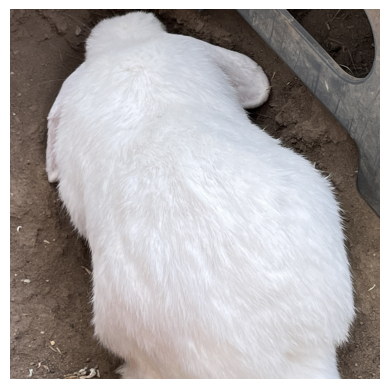

In [4]:
images = save_rabbit_crops(r'F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\26062025\Helios\FullSizeRender-57.jpg')

for img in images:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Remove Duplicates
Remove what seems to be duplicates from the folders with Marie's function

In [ ]:
# base_path = r"D:\HKA_IMS_Drive\SS25_MSYS_KAER-AI-PoseAct\21_Test_Data\dataset_aufgabe2_cropped_wo_duplicates"  # Directory to save cropped images
base_path = r"F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\xx_ProcessedImagesJanik\ProcessedImagesJanik"
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

for subdir in subdirs:
    remove_visual_duplicates(folder=os.path.join(base_path, subdir),threshold=8)

Auto-deleting duplicate: IMG_20250604_155104_sheep_1.jpg (duplicate of IMG_20250604_155104_bird_0.jpg)
Auto-deleting duplicate: IMG_20250604_155110_sheep_1.jpg (duplicate of IMG_20250604_155110_bird_0.jpg)
Auto-deleting duplicate: IMG_20250604_155112_bird_1.jpg (duplicate of IMG_20250604_155110_bird_0.jpg)
Auto-deleting duplicate: IMG_20250604_155112_sheep_0.jpg (duplicate of IMG_20250604_155110_bird_0.jpg)
Auto-deleting duplicate: IMG_20250604_155118_sheep_0.jpg (duplicate of IMG_20250604_155118_bird_1.jpg)
Auto-deleting duplicate: IMG_20250604_155125_sheep_1.jpg (duplicate of IMG_20250604_155125_bear_0.jpg)
Auto-deleting duplicate: IMG_20250604_155138_sheep_0.jpg (duplicate of IMG_20250604_155138_bear_1.jpg)
Auto-deleting duplicate: IMG_20250604_155143_bear_0.jpg (duplicate of IMG_20250604_155140_bear_0.jpg)
Auto-deleting duplicate: IMG_20250604_155146_bird_0.jpg (duplicate of IMG_20250604_155146_bear_1.jpg)
Auto-deleting duplicate: IMG_20250604_155158_bear_0.jpg (duplicate of IMG_20

: 